In [2]:
import tensorflow as tf
import tensorflow.keras
import pydot
import graphviz
# coding: utf-8
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.optimizers import SGD  #Stochastic gradient descent optimizer.
#import matplotlib
import numpy as np
#import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout 
from tensorflow.keras.optimizers import Adam, RMSprop, Adamax 
from tensorflow.keras.callbacks import EarlyStopping
import os
from tensorflow.keras.models import model_from_json, load_model
from tensorflow.keras.layers import LeakyReLU, PReLU, BatchNormalization  
import sklearn
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import Callback
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
train_data = pd.read_csv("D:/cow_data_original_test/train_data_weight_spec_df_final.csv")
test_data = pd.read_csv("D:/cow_data_original_test/test_data_weight_spec_df_final.csv")
del train_data["Unnamed: 0"]
del test_data["Unnamed: 0"]

In [4]:
train_data.head()

,ID,record_year,record_month,farm_code,cow_number,father_cow_semen_number,mother_cow_semen_number,parity_count,lactation_days,month_age,breeding_count,first_breeding_semen,milk_volume,cow weight,health,season
0,1.0,2013.0,3.0,A,52612,507H7173,96040545,1.0,78.0,26.0,1.0,501H8784,29.4,575.275099,0,spring
1,2.0,2013.0,4.0,A,52612,507H7173,96040545,1.0,107.0,27.0,1.0,501H8784,27.8,575.275099,0,spring
2,3.0,2013.0,5.0,A,52612,507H7173,96040545,1.0,140.0,28.0,2.0,501H8784,9.0,575.275099,0,spring
3,4.0,2013.0,6.0,A,52612,507H7173,96040545,1.0,175.0,29.0,2.0,501H8784,13.0,575.275099,0,summer
4,5.0,2013.0,7.0,A,52612,507H7173,96040545,1.0,210.0,30.0,2.0,501H8784,13.2,575.275099,0,summer


In [5]:
## drop by Name
xtrain = train_data.drop(['milk_volume', 'father_cow_semen_number', 'mother_cow_semen_number', 'first_breeding_semen'], axis=1)
ytrain = train_data["milk_volume"]
xsubmission = test_data.drop(['father_cow_semen_number', 'mother_cow_semen_number', 'first_breeding_semen'], axis=1)
#對缺值補值
xtrain=xtrain.fillna(0)
xsubmission=xsubmission.fillna(0)

In [6]:
# get dummy
xtrain = pd.get_dummies(xtrain, columns = ['farm_code'])
xtrain = pd.get_dummies(xtrain, columns = ['season'])
# xtrain = pd.get_dummies(xtrain, columns = ['no_milk_bool'])
xsubmission = pd.get_dummies(xsubmission, columns = ['farm_code'])
xsubmission = pd.get_dummies(xsubmission, columns = ['season'])
# xsubmission = pd.get_dummies(xsubmission, columns = ['no_milk_bool'])

In [7]:
xtrain = pd.DataFrame( data = xtrain, columns = ['ID',
 'record_year',
 'record_month',
 'cow_number',
 'parity_count',
 'lactation_days',
 'month_age',
 'breeding_count',
 'cow weight',
 'health',
 'farm_code_A',
 'farm_code_B',
 'farm_code_C',
 'season_spring',
 'season_summer',
 'season_winter',
 'season_fall'])#,
#     'no_milk_bool'])
xsubmission["season_fall"] = 0
xsubmission = pd.DataFrame( data = xsubmission, columns = ['ID',
 'record_year',
 'record_month',
 'cow_number',
 'parity_count',
 'lactation_days',
 'month_age',
 'breeding_count',
 'cow weight',
 'health',
 'farm_code_A',
 'farm_code_B',
 'farm_code_C',
 'season_spring',
 'season_summer',
 'season_winter',
 'season_fall'])#,
#     'no_milk_bool'])

In [8]:
xsubmission.tail()

,ID,record_year,record_month,cow_number,parity_count,lactation_days,month_age,breeding_count,cow weight,health,farm_code_A,farm_code_B,farm_code_C,season_spring,season_summer,season_winter,season_fall
4258,37481.0,2019,6,6187446,1.0,15.0,24.0,0.0,540.0,0.0,0,0,1,0,1,0,0
4259,37482.0,2019,6,6187448,1.0,22.0,24.0,0.0,490.0,0.0,0,0,1,0,1,0,0
4260,37483.0,2019,6,6187449,1.0,21.0,22.0,0.0,540.0,0.0,0,0,1,0,1,0,0
4261,37484.0,2019,7,6187449,1.0,51.0,23.0,0.0,540.0,0.0,0,0,1,0,1,0,0
4262,37485.0,2019,7,6187451,1.0,15.0,23.0,0.0,505.0,0.0,0,0,1,0,1,0,0


In [9]:
#設定訓練集和驗證集
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(xtrain,ytrain,test_size=0.2,random_state=2)

In [11]:
from sklearn.ensemble import RandomForestRegressor

mse_list = []
# Create a new random forest classifier for the most important features
for i in range(50):
    clf_important_ls= RandomForestRegressor(random_state=i)

    # Train the new classifier on the new dataset containing the most important features
    clf_important_ls.fit(x_train, y_train)
    y_important_pred = clf_important_ls.predict(x_test)
    # print(y)
    # from sklearn.metrics import accuracy_score
    # View The Accuracy Of Our Full Feature (4 Features) Model
#     print(f" r2:",r2_score(y_test[:],y_important_pred[:]).round(2))
    mse = mean_squared_error(y_test[:],y_important_pred[:])
#     print(f"mse:",mse.round(2))
    mse_list.append(mse)


In [12]:
train_data.shape

(33238, 16)

In [13]:
other_params_opt = {'eta': 0.3,'n_estimators': 500,"learning_rate": 0.1, 'gamma': 0, 'max_depth': 7, 'min_child_weight': 1, "objective":'reg:linear',
                'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'subsample': 0.85, 'reg_lambda': 1, 'reg_alpha': 0, "max_delta_step":0 ,"nthread":-1,
                'seed': 1440,"scale_pos_weight":1}

xg_reg = xgb.XGBRegressor(**other_params_opt)

In [14]:
xg_reg.fit(x_train, y_train)

[17:24:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
       eta=0.3, gamma=0, gpu_id=-1, importance_type=None,
       interaction_constraints='', learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=nan,
       monotone_constraints='()', n_estimators=500, n_jobs=8, nthread=-1,
       num_parallel_tree=1, objective='reg:linear', predictor='auto',
       random_state=1440, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=1440, subsample=0.85, tree_method='exact',
       validate_parameters=1, verbosity=None)

In [15]:
y_pred = xg_reg.predict(x_test)

In [16]:
print(f" r2:",r2_score(y_test,y_pred).round(2))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"rmse:",rmse.round(2))

 r2: 0.67
rmse: 4.98


In [17]:
y_pred[:10]

array([21.490246, 27.748276, 17.255856, 31.805534, 30.606173, 29.883865,
       26.844   , 20.916855, 15.958651, 16.758698], dtype=float32)

In [18]:
y_test = y_test.reset_index()
# y_pred = y_pred.reset_index(True)
# df_train = df_train.reset_index()

In [19]:
y_test[:5]

,index,milk_volume
0,2949,24.0
1,5400,26.8
2,27481,20.0
3,17032,35.0
4,8698,30.0


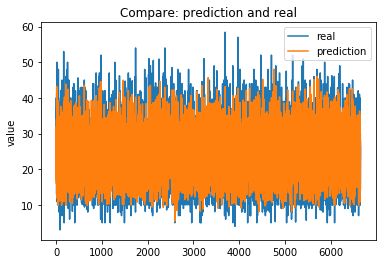

In [20]:
plt.plot(y_test.iloc[:,1], label ="real")
plt.plot(y_pred,label ="prediction")

plt.title(f"Compare: prediction and real" )
plt.ylabel("value")
plt.legend(loc = "upper right")
plt.show()

In [21]:
print(f" r2:",r2_score(y_test,y_pred).round(2))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"rmse:",rmse.round(2))

ValueError: y_true and y_pred have different number of output (2!=1)

In [46]:
y_submission = xg_reg.predict(xsubmission)
submission_data = pd.DataFrame( data = xsubmission.iloc[:,0])
submission_data["pred"] = y_submission.tolist()
submission_data.head()

,ID,pred
0,480.0,17.235516
1,742.0,28.358360
2,743.0,30.701571
3,744.0,29.552948
4,745.0,22.681528


In [49]:
submission_data.to_csv("D:/cow_data_original_test/submission_data_xgb_gs_1121_untitled1_nofarm_code.csv", index = False)

In [47]:
importances = xg_reg.feature_importances_

<Container object of 17 artists>

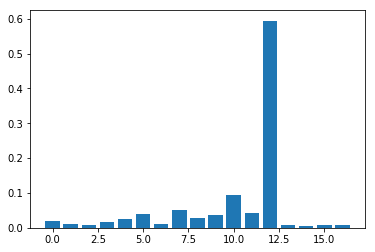

In [37]:
plt.bar(range(len(importances)), importances)

Text(0.5,1,'Feature Importance')

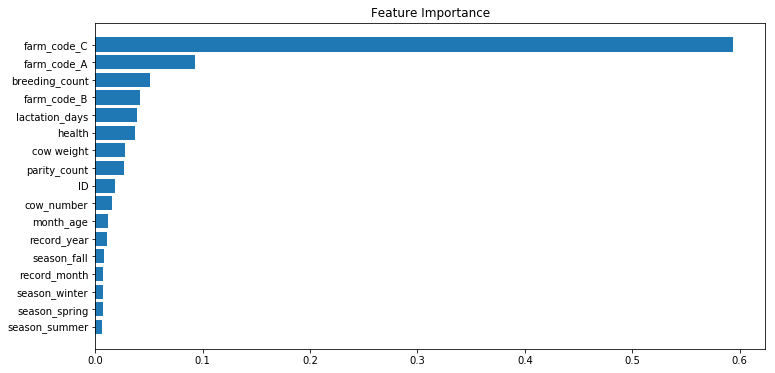

In [65]:
feature_importance = xg_reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x_test.columns)[sorted_idx])
plt.title('Feature Importance')